In [1]:
#!pip install kagglehub
#!pip install optuna

In [2]:
import kagglehub

path = kagglehub.dataset_download("arshkon/linkedin-job-postings")

print("Path to dataset files:", path)

Path to dataset files: /Users/stellachen/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13


In [3]:
import pandas as pd
import numpy as np
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Create TD / TF-IDF Matricies
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression # Preform Logistic Regression
from sklearn.metrics import confusion_matrix # Make the Confustion Matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score # for AUC, fpr, tpr, threshold and accuracy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from nltk.corpus import stopwords # for the Stopwords list
from nltk.stem import PorterStemmer # for the porter Stemmer
import nltk # for other nltk functions
import re # for regular expression functions
nltk.download('punkt_tab')

from tqdm import tqdm  # for progress bar
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/stellachen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
postings_df = pd.read_csv(f"{path}/postings.csv")
postings_df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [5]:
# Load the Job Postings CSV file into a Pandas DataFrame
jimap_df = pd.read_csv(f"{path}/jobs/job_industries.csv")
ins_df = pd.read_csv(f"{path}/mappings/industries.csv")

# print the industries related to IT/software derived from chat gpt
IT_IND_KEYWORDS = [
    "Software",
    "IT Services",
    "IT System",
    "Computer",
    "Data Security Software Products",
    "Blockchain",
    "Internet",
    "Social Networking",
    "Business Intelligence",
    "E-Learning",
]
IT_IND_STOPWORDS = [
    "Publishing",
    "News",
    "Hardware",
    "Equipment"
]
# print('|'.join(IT_IND_KEYWORDS))
ins_include = ins_df['industry_name'].str.contains('|'.join(IT_IND_KEYWORDS), na=False)
ins_exlcude = ins_df['industry_name'].str.contains('|'.join(IT_IND_STOPWORDS),na=False )

ins_it = ins_df[ins_include]
ins_it = ins_it[~ins_exlcude]

print(ins_it)

     industry_id                            industry_name
2              4                     Software Development
3              5             Computer Networking Products
4              6     Technology, Information and Internet
22            24  Computers and Electronics Manufacturing
93            96            IT Services and IT Consulting
106          109                           Computer Games
115          118            Computer and Network Security
129          132                     E-Learning Providers
226         1285           Internet Marketplace Platforms
268         1855                IT System Design Services
342         3101      Desktop Computing Software Products
343         3102    IT System Custom Software Development
344         3103     IT System Operations and Maintenance
345         3104      IT System Installation and Disposal
346         3105           IT System Training and Support
347         3106                  IT System Data Services
348         31

/var/folders/gb/7v068m41117fznc0hh2hds0r0000gn/T/ipykernel_25926/197863923.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ins_it = ins_it[~ins_exlcude]


In [6]:
df_itpos = pd.merge(pd.merge(ins_it,jimap_df,on='industry_id'), postings_df, on='job_id')
print(f'the shape of df_itpos: {df_itpos.shape}')
df_itpos.head()

the shape of df_itpos: (18675, 33)


,industry_id,industry_name,job_id,company_name,title,description,max_salary,pay_period,location,company_id,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,4,Software Development,3884916106,"Direct Sales Recruiting, LLC",Sales Manager - Public Relations & Investor Re...,Sales Manager - Public Relations & Investor Re...,NaN,NaN,New York City Metropolitan Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
1,96,IT Services and IT Consulting,3884916106,"Direct Sales Recruiting, LLC",Sales Manager - Public Relations & Investor Re...,Sales Manager - Public Relations & Investor Re...,NaN,NaN,New York City Metropolitan Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
2,4,Software Development,3884915161,"Direct Sales Recruiting, LLC",Business Development Rep - Digital Media - Chi...,Business Development Rep - Digital Media \nOur...,80000.0,YEARLY,Greater Chicago Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,65000.0,NaN,NaN
3,96,IT Services and IT Consulting,3884915161,"Direct Sales Recruiting, LLC",Business Development Rep - Digital Media - Chi...,Business Development Rep - Digital Media \nOur...,80000.0,YEARLY,Greater Chicago Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,65000.0,NaN,NaN
4,4,Software Development,3887466954,hackajob,Cloud Engineer,hackajob transforms your job search into a per...,160000.0,YEARLY,"Suitland, MD",5396873.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,135000.0,20746.0,24033.0


In [7]:
df_itpos.to_csv('data/IT_postings.csv')

In [8]:
df_itpos['industry_name'].unique()

array(['Software Development', 'IT Services and IT Consulting',
       'Technology, Information and Internet',
       'Computers and Electronics Manufacturing',
       'Computer and Network Security',
       'IT System Custom Software Development', 'Computer Games',
       'Computer Networking Products', 'E-Learning Providers',
       'IT System Training and Support', 'IT System Data Services',
       'Internet Marketplace Platforms',
       'IT System Testing and Evaluation', 'IT System Design Services',
       'IT System Installation and Disposal',
       'Desktop Computing Software Products',
       'IT System Operations and Maintenance',
       'Social Networking Platforms', 'Business Intelligence Platforms',
       'Data Security Software Products', 'Blockchain Services',
       'Computer Networking'], dtype=object)

In [9]:
df_itpos.shape

(18675, 33)

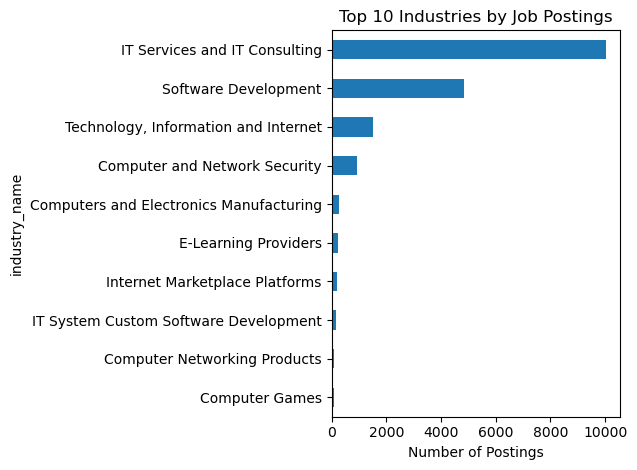

In [10]:
top_industries = df_itpos['industry_name'].value_counts().nlargest(10)

top_industries.plot(kind='barh')
plt.title('Top 10 Industries by Job Postings')
plt.xlabel('Number of Postings')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


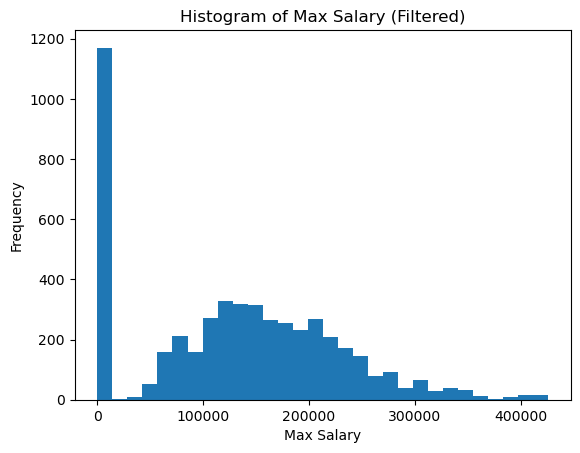

In [11]:
# Filter out salaries above the 99th percentile
threshold = df_itpos['max_salary'].quantile(0.99)

# Drop nulls and apply threshold
filtered = df_itpos[df_itpos['max_salary'] <= threshold]['max_salary'].dropna()

# Plot
filtered.plot(kind='hist', bins=30)
plt.title('Histogram of Max Salary (Filtered)')
plt.xlabel('Max Salary')
plt.ylabel('Frequency')
plt.show()



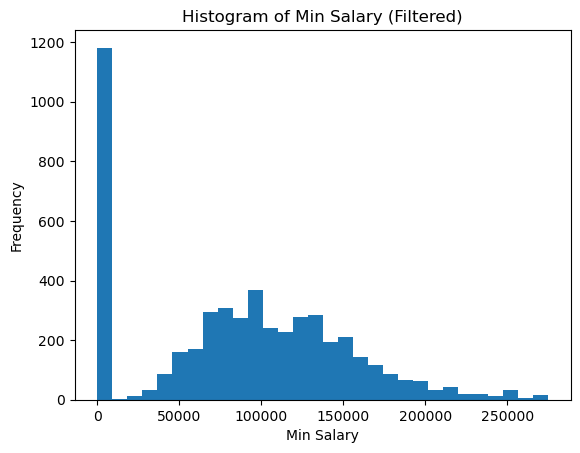

In [12]:
# Filter out salaries above the 99th percentile
threshold = df_itpos['min_salary'].quantile(0.99)

# Drop nulls and apply threshold
filtered = df_itpos[df_itpos['min_salary'] <= threshold]['min_salary'].dropna()

# Plot
filtered.plot(kind='hist', bins=30)
plt.title('Histogram of Min Salary (Filtered)')
plt.xlabel('Min Salary')
plt.ylabel('Frequency')
plt.show()

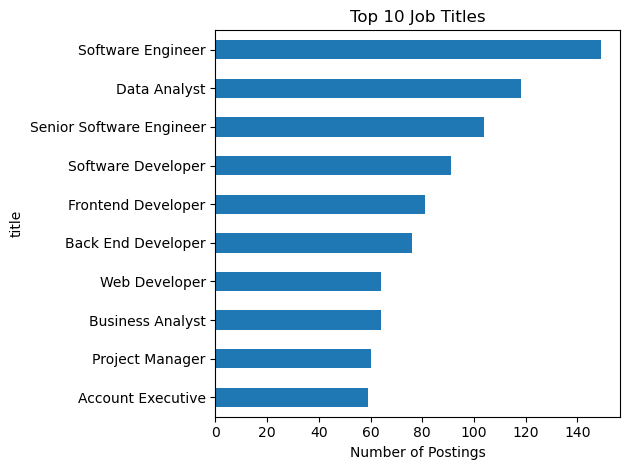

In [13]:
top_titles = df_itpos['title'].value_counts().nlargest(10)

top_titles.plot(kind='barh')
plt.title('Top 10 Job Titles')
plt.xlabel('Number of Postings')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [14]:
df_itpos

,industry_id,industry_name,job_id,company_name,title,description,max_salary,pay_period,location,company_id,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,4,Software Development,3884916106,"Direct Sales Recruiting, LLC",Sales Manager - Public Relations & Investor Re...,Sales Manager - Public Relations & Investor Re...,NaN,NaN,New York City Metropolitan Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
1,96,IT Services and IT Consulting,3884916106,"Direct Sales Recruiting, LLC",Sales Manager - Public Relations & Investor Re...,Sales Manager - Public Relations & Investor Re...,NaN,NaN,New York City Metropolitan Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
2,4,Software Development,3884915161,"Direct Sales Recruiting, LLC",Business Development Rep - Digital Media - Chi...,Business Development Rep - Digital Media \nOur...,80000.0,YEARLY,Greater Chicago Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,65000.0,NaN,NaN
3,96,IT Services and IT Consulting,3884915161,"Direct Sales Recruiting, LLC",Business Development Rep - Digital Media - Chi...,Business Development Rep - Digital Media \nOur...,80000.0,YEARLY,Greater Chicago Area,766849.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,65000.0,NaN,NaN
4,4,Software Development,3887466954,hackajob,Cloud Engineer,hackajob transforms your job search into a per...,160000.0,YEARLY,"Suitland, MD",5396873.0,...,NaN,1.712346e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,135000.0,20746.0,24033.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18670,3234,Computer Networking,3894568283,Internet2,Remote Part-Time Intern - Cloud Programs,Internet2 is seeking a Part Time Cloud Program...,NaN,NaN,United States,19264.0,...,NaN,1.712893e+12,workforcenow.adp.com,0,PART_TIME,NaN,NaN,NaN,NaN,NaN
18671,3234,Computer Networking,3894568284,Internet2,Accounting Assistant - Hybrid in Ann Arbor,"Accounting Assistant, Hybrid (1 day in office)...",NaN,NaN,"Ann Arbor, MI",19264.0,...,NaN,1.712893e+12,workforcenow.adp.com,0,FULL_TIME,NaN,NaN,NaN,48103.0,26161.0
18672,3234,Computer Networking,3901944513,Sercomm,System Engineer,"Sercomm Technology Inc., is the U.S. subsidiar...",NaN,NaN,United States,22348.0,...,NaN,1.713474e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN
18673,3234,Computer Networking,3902320466,Allied Telesis,Product Manager,Company Description Allied Telesis is a leadin...,NaN,NaN,San Francisco Bay Area,5584.0,...,NaN,1.713515e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,NaN,NaN


**Predicting experience level using description**

In [15]:

want =  ["description","formatted_experience_level"]
df = postings_df[want]
# Dropping Missing Values
df = df.dropna(subset=['formatted_experience_level']).reset_index(drop=True)

Modeling using specific features

In [16]:
def Features(df, column_name):
    feature_columns = ['word_cnt', 'sent_cnt', 'vocab_cnt', 'Avg_sent_word_cnt', 'lexical_richness','Readability_index']
    feature_data = []

    for index, row in df.iterrows():
        text = row[column_name]

        # Simple features (Word Count, sentence Count, Vocabulary Count, Lexical Diversity)
        tokens = nltk.word_tokenize(text)
        char_cnt = len(tokens)

        words = [w for w in tokens if w.isalpha()]
        word_cnt = len(words)

        avg_word_length = char_cnt/word_cnt

        sents = nltk.sent_tokenize(text)
        sent_cnt = len(sents)

        avg_sent_length = word_cnt / sent_cnt if sent_cnt > 0 else 0
        avg_sent_length = round(avg_sent_length,2)

        vocab = set(words)
        vocab_cnt = len(vocab)

        lex_richness = round(vocab_cnt / word_cnt, 4)

        ARI = 4.71*avg_word_length + .5*avg_sent_length - 21.43

        # Append the column data
        feature_data.append([word_cnt, sent_cnt, vocab_cnt, avg_sent_length, lex_richness ,ARI]) # dropped avg_sent_length

    feature_df = pd.DataFrame(feature_data, columns=feature_columns)

    # Combine the original DataFrame with the new DataFrame containing features
    result_df = pd.concat([df, feature_df], axis=1)

    return result_df

In [17]:
FE_df = Features(df,'description')

In [18]:
FE_df['Cust_Service'] = FE_df['description'].apply(lambda x: 1 if 'customer service' in x.lower() else 0)
FE_df['diploma_ged'] = FE_df['description'].apply(lambda x: 1 if 'diploma ged' in x.lower() else 0)
FE_df['per_hour'] = FE_df['description'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
FE_df['diploma_equiv'] = FE_df['description'].apply(lambda x: 1 if 'diploma equivalent' in x.lower() else 0)
FE_df['project_management'] = FE_df['description'].apply(lambda x: 1 if 'project management' in x.lower() else 0)
FE_df['cross_functional'] = FE_df['description'].apply(lambda x: 1 if 'cross functional' in x.lower() else 0)
FE_df['minimum_years'] = FE_df['description'].apply(lambda x: 1 if 'minimum years' in x.lower() else 0)
FE_df['experience_working'] = FE_df['description'].apply(lambda x: 1 if 'experience working' in x.lower() else 0)
FE_df['management'] = FE_df['description'].apply(lambda x: 1 if 'management ' in x.lower() else 0)
FE_df['track_record'] = FE_df['description'].apply(lambda x: 1 if 'track_record ' in x.lower() else 0)

In [19]:
x_fe = FE_df.drop(['description', 'formatted_experience_level'], axis=1)
y_fe = FE_df['formatted_experience_level']

In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_fe, y_fe, test_size = 0.2, random_state = 1)

In [21]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train2, y_train2)

In [22]:
scaler = MinMaxScaler()
X_train_resampled_normalized = scaler.fit_transform(X_train_resampled)
X_test2_normalized = scaler.transform(X_test2)

X_train_resampled_normalized = pd.DataFrame(X_train_resampled_normalized, columns=X_train2.columns)
X_test2_normalized = pd.DataFrame(X_test2_normalized, columns=X_test2.columns)

Random Forest

In [23]:
def objective(trial):
    start = time.time()
    param_dist = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_features': trial.suggest_categorical('max_features', ['sqrt',None]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2,20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,20)
    }

    rf_fe = RandomForestClassifier(criterion='entropy', random_state=42, n_jobs=-1, **param_dist)
    cv_scores = cross_val_score(rf_fe, X_train_resampled_normalized, y_train_resampled, cv=6)
    print(f"Trial {trial.number} took {time.time() - start:.2f} seconds", flush = True)
    return cv_scores.mean()

In [25]:
start_time = time.time() # record time
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=5)
end_time = time.time() # record time

[I 2025-05-20 10:24:54,594] A new study created in memory with name: no-name-b893c0e5-beda-4f7b-94ae-c326e697eab4


Trial 0 took 30.99 seconds


[I 2025-05-20 10:25:25,593] Trial 0 finished with value: 0.7773832806780002 and parameters: {'n_estimators': 140, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.7773832806780002.


Trial 1 took 274.81 seconds


[I 2025-05-20 10:30:00,415] Trial 1 finished with value: 0.8171656386339702 and parameters: {'n_estimators': 427, 'max_features': None, 'min_samples_split': 16, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.8171656386339702.


Trial 2 took 116.28 seconds


[I 2025-05-20 10:31:56,698] Trial 2 finished with value: 0.8101348979489492 and parameters: {'n_estimators': 148, 'max_features': None, 'min_samples_split': 19, 'min_samples_leaf': 12}. Best is trial 1 with value: 0.8171656386339702.


Trial 3 took 185.63 seconds


[I 2025-05-20 10:35:02,330] Trial 3 finished with value: 0.8503384985707837 and parameters: {'n_estimators': 231, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8503384985707837.


Trial 4 took 227.39 seconds


[I 2025-05-20 10:38:49,724] Trial 4 finished with value: 0.8426758938869666 and parameters: {'n_estimators': 317, 'max_features': None, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8503384985707837.


In [ ]:
#Computing Training Duration
rf_fe_tt = end_time - start_time
print(f"Training Duration: {rf_fe_tt} Seconds")
print("Best Hyperparameters:", study_rf.best_trial.params)
mean_acc_rffe = study_rf.best_value
print(f"6-Fold Cross-Validation Accuracy: {mean_acc_rffe}")

Training Duration: 835.1380343437195 Seconds
Best Hyperparameters: {'n_estimators': 231, 'max_features': None, 'min_samples_split': 13, 'min_samples_leaf': 6}
10-Fold Cross-Validation Accuracy: 0.8503384985707837


In [27]:
# Best model from hyperparameter tuning
rf_fe = RandomForestClassifier(criterion='entropy', random_state=42, **study_rf.best_trial.params)
rf_fe.fit(X_train_resampled_normalized, y_train_resampled)

# Predict on train and test datasets
y_test_pred_rffe = rf_fe.predict(X_test2_normalized)

#Test Accuracy
test_acc_rffe = accuracy_score(y_test2, y_test_pred_rffe)
print(f"Test Accuracy: {test_acc_rffe:.2%}")

Test Accuracy: 55.10%


In [28]:
# Compute test probabilities, false positive rate, true positive rate, and auc
# Compute test probabilities for each class
y_test_prob_gbmfe = rf_fe.predict_proba(X_test2_normalized)

# Compute ROC curve and AUC for each class
fpr_gbmfe = {}
tpr_gbmfe = {}
threshold_gbmfe = {}
auc_score_gbmfe = {}

for i, class_name in enumerate(rf_fe.classes_):
    fpr_gbmfe[class_name], tpr_gbmfe[class_name], threshold_gbmfe[class_name] = roc_curve(
        (y_test2 == class_name).astype(int), y_test_prob_gbmfe[:, i]
    )
    auc_score_gbmfe[class_name] = roc_auc_score(
        (y_test2 == class_name).astype(int), y_test_prob_gbmfe[:, i]
    )

# Print AUC for each class
for class_name, auc in auc_score_gbmfe.items():
    print(f"AUC Score for {class_name}: {auc:.2%}")


AUC Score for Associate: 75.32%
AUC Score for Director: 75.44%
AUC Score for Entry level: 78.47%
AUC Score for Executive: 68.96%
AUC Score for Internship: 72.65%
AUC Score for Mid-Senior level: 72.05%


In [ ]:
# Feature Importance
feature_importances = pd.Series(rf_fe.feature_importances_, index=X_train_resampled_normalized.columns)
print("Feature Importance:")
print(feature_importances.sort_values(ascending=False))

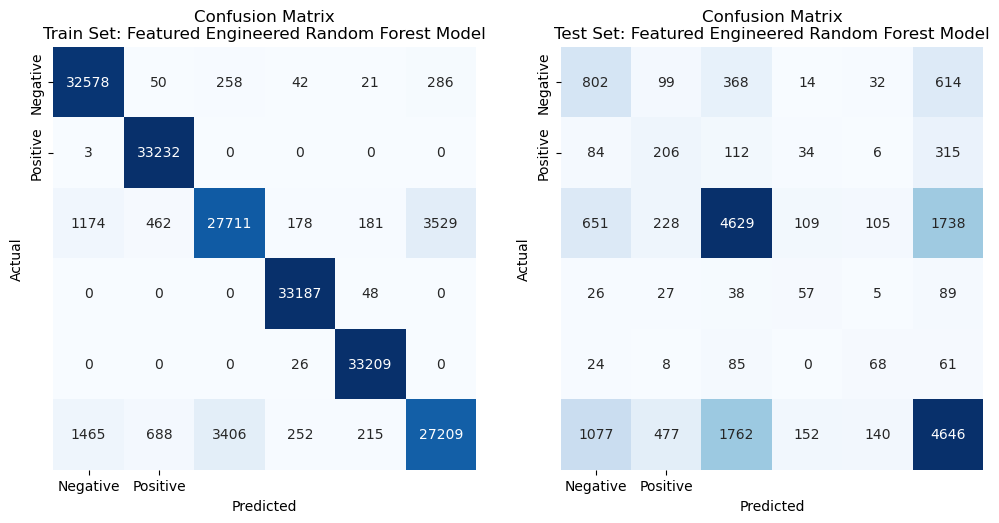

In [29]:
# Compute confusion matrices
y_train_pred_rffe = rf_fe.predict(X_train_resampled_normalized)
conf_matrix_train_rffe = confusion_matrix(y_train_resampled, y_train_pred_rffe)
conf_matrix_test_rffe = confusion_matrix(y_test2, y_test_pred_rffe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_rffe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: Featured Engineered Random Forest Model')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_rffe, annot=True, fmt='d', cmap='Blues', square=True,cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=[ 'Negative','Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: Featured Engineered Random Forest Model');

**Gradient Boost**

We didn't do cross validation here because it was taking a very long time so I manually set the parameters

In [36]:
# Best model from hyperparameter tuning
gbm_fe = GradientBoostingClassifier(
    n_estimators=317,
    max_features=None,
    min_samples_split=15,
    min_samples_leaf=7,
    random_state=42
)

gbm_fe.fit(X_train_resampled_normalized, y_train_resampled)
gbm_fe.fit(X_train_resampled_normalized, y_train_resampled)

GradientBoostingClassifier(min_samples_leaf=7, min_samples_split=15,
                           n_estimators=317, random_state=42)

In [37]:
# For multiclass classification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Predict class labels
y_test_pred_gbmfe = gbm_fe.predict(X_test2_normalized)
test_acc_gbmfe = accuracy_score(y_test2, y_test_pred_gbmfe)
print(f"Test Accuracy: {test_acc_gbmfe:.2%}")

# Get precision, recall, and F1 for all classes
precision_gbmfe, recall_gbmfe, f1_gbmfe, _ = precision_recall_fscore_support(y_test2, y_test_pred_gbmfe, average=None)
print(f"Precision per class: {precision_gbmfe}")
print(f"Recall per class: {recall_gbmfe}")
print(f"F1-Score per class: {f1_gbmfe}")

# For average metrics across all classes
precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(y_test2, y_test_pred_gbmfe, average='weighted')
print(f"Weighted Precision: {precision_avg:.2%}")
print(f"Weighted Recall: {recall_avg:.2%}")
print(f"Weighted F1-Score: {f1_avg:.2%}")

# For multiclass ROC AUC
y_test_prob_gbmfe = gbm_fe.predict_proba(X_test2_normalized)
auc_score_gbmfe = roc_auc_score(y_test2, y_test_prob_gbmfe, multi_class='ovr')
print(f"AUC Score (OVR): {auc_score_gbmfe:.2%}")

Test Accuracy: 31.51%
Precision per class: [0.20910384 0.10191926 0.60598018 0.04537622 0.03716449 0.63206628]
Recall per class: [0.38102644 0.40686922 0.45911528 0.32644628 0.43902439 0.15713593]
F1-Score per class: [0.27002204 0.16300609 0.52242221 0.07967726 0.06852792 0.25169804]
Weighted Precision: 54.21%
Weighted Recall: 31.51%
Weighted F1-Score: 35.24%
AUC Score (OVR): 70.65%


In [38]:
# Feature Importance
feature_importances_gbmfe = pd.Series(gbm_fe.feature_importances_, index=X_train_resampled_normalized.columns)
print("Feature Importance:")
print(feature_importances_gbmfe.sort_values(ascending=False))

Feature Importance:
lexical_richness      0.208414
Readability_index     0.193760
vocab_cnt             0.142208
Avg_sent_word_cnt     0.124909
word_cnt              0.109777
management            0.078240
sent_cnt              0.060291
Cust_Service          0.036673
per_hour              0.019317
project_management    0.011837
experience_working    0.007405
cross_functional      0.004965
minimum_years         0.002168
diploma_ged           0.000035
diploma_equiv         0.000000
track_record          0.000000
dtype: float64


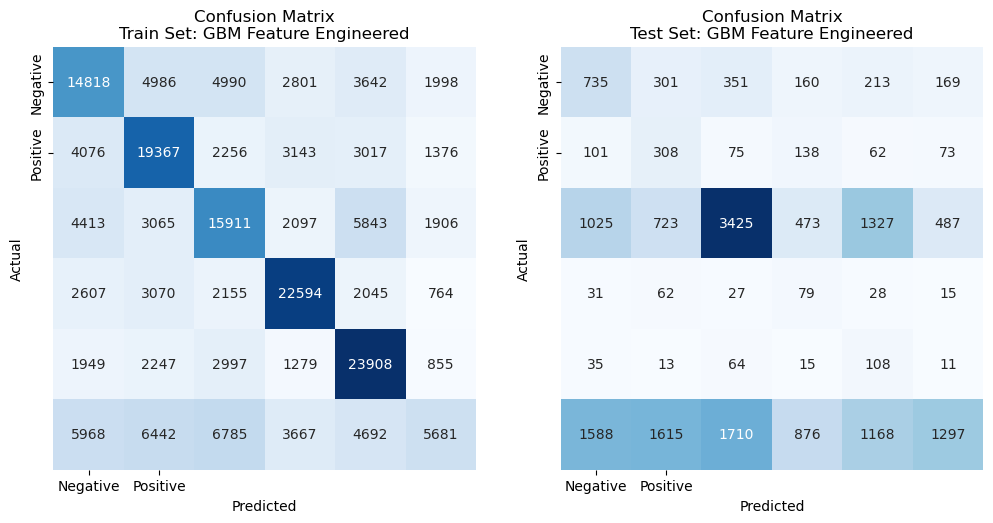

In [39]:
# Compute confusion matrices
y_train_pred_gbmfe = gbm_fe.predict(X_train_resampled_normalized)
conf_matrix_train_gbmfe = confusion_matrix(y_train_resampled, y_train_pred_gbmfe)
conf_matrix_test_gbmfe = confusion_matrix(y_test2, y_test_pred_gbmfe)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# First heatmap for Train Set
sns.heatmap(conf_matrix_train_gbmfe, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix\nTrain Set: GBM Feature Engineered')

# Second heatmap for Test Set
sns.heatmap(conf_matrix_test_gbmfe, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix\nTest Set: GBM Feature Engineered');

plt.show()